In [1]:
import numpy as np
import pandas as pd
import glob

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# Define the data path (update the path accordingly)
path = '/kaggle/input/march-machine-learning-mania-2025/**'

# Load all CSV files from the dataset directory into a dictionary
# The key is the filename (without extension), and the value is the corresponding DataFrame
data = {p.split('/')[-1].split('.')[0]: pd.read_csv(p, encoding='latin-1') for p in glob.glob(path)}

# Add Gender marker before concatenating teams (M for Men's, W for Women's)
data['MTeams']['Gender'] = '1'
data['WTeams']['Gender'] = '0'

# Merge men's and women's team data into a single DataFrame
teams = pd.concat([data['MTeams'], data['WTeams']])

# Merge team spellings and count variations for each TeamID
teams_spelling = pd.concat([data['MTeamSpellings'], data['WTeamSpellings']])
teams_spelling = teams_spelling.groupby('TeamID', as_index=False).size()
teams_spelling.columns = ['TeamID', 'TeamNameCount']

# Merge spelling variations count with the teams DataFrame
teams = teams.merge(teams_spelling, how='left', on='TeamID')

del teams_spelling  # Clean up memory

# Merge season results (compact and detailed) for men's and women's data
season_cresults = pd.concat([data['MRegularSeasonCompactResults'], data['WRegularSeasonCompactResults']])
season_dresults = pd.concat([data['MRegularSeasonDetailedResults'], data['WRegularSeasonDetailedResults']])
tourney_cresults = pd.concat([data['MNCAATourneyCompactResults'], data['WNCAATourneyCompactResults']])
tourney_dresults = pd.concat([data['MNCAATourneyDetailedResults'], data['WNCAATourneyDetailedResults']])
slots = pd.concat([data['MNCAATourneySlots'], data['WNCAATourneySlots']])
seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']])
gcities = pd.concat([data['MGameCities'], data['WGameCities']])
seasons = pd.concat([data['MSeasons'], data['WSeasons']])

# Convert seeds into a dictionary where keys are "Season_TeamID" and values are numeric seed values
seeds = {'_'.join(map(str, [int(k1), k2])): int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}

# Load other relevant data
cities = data['Cities']
sub = data['SampleSubmissionStage2']
rankings = data['MMasseyOrdinals']
del data  # Clean up memory

# Add season type labels to the game results datasets
season_cresults['ST'] = 'S'
season_dresults['ST'] = 'S'
tourney_cresults['ST'] = 'T'
tourney_dresults['ST'] = 'T'

# Combine detailed season and tournament results
# Only detailed results are used since they contain richer statistics
games = pd.concat([season_dresults, tourney_dresults], axis=0, ignore_index=True)
games.reset_index(drop=True, inplace=True)

# Map win location to numerical values
games['WLoc'] = games['WLoc'].map({'A': 1, 'H': 2, 'N': 3})

# Generate unique game identifiers and related team IDs
games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season']] + sorted([r['WTeamID'], r['LTeamID']]))), axis=1)
games['IDTeams'] = games.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'], r['LTeamID']]))), axis=1)
games['Team1'], games['Team2'] = zip(*games[['WTeamID', 'LTeamID']].apply(lambda x: sorted(x), axis=1))
games['IDTeam1'] = games.apply(lambda r: f"{r['Season']}_{r['Team1']}", axis=1)
games['IDTeam2'] = games.apply(lambda r: f"{r['Season']}_{r['Team2']}", axis=1)

# Map team seeds to the games dataset
games['Team1Seed'] = games['IDTeam1'].map(seeds).fillna(0)
games['Team2Seed'] = games['IDTeam2'].map(seeds).fillna(0)

games['ScoreDiff'] = games['WScore'] - games['LScore']

# Label the winning team as Team1 for predictions
games['Pred'] = (games['WTeamID'] == games['Team1']).astype(float)

games['ScoreDiffNorm'] = games['ScoreDiff'] * (-1 + 2 * games['Pred'])
games['SeedDiff'] = games['Team1Seed'] - games['Team2Seed']

games.fillna(-1, inplace=True)  # Fill missing values with -1

# Select statistics columns for aggregation
c_score_col = ['NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',
 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',
 'LBlk', 'LPF']

c_score_agg = ['mean', 'std']

# Aggregate statistics for each game pair
gb = games.groupby('IDTeams').agg({k: c_score_agg for k in c_score_col}).reset_index()

# Rename columns for clarity
gb.columns = [''.join(c) + '_c_score' for c in gb.columns]

games = games[games['ST'] == 'T']  # Keep only tournament games

# Prepare submission dataset
sub['WLoc'] = 3
sub['ScoreDiff'] = 0
#sub['DayNum'] = 0
sub[['Season', 'Team1', 'Team2']] = sub['ID'].str.split('_', expand=True).astype(int)
sub['IDTeams'] = sub.apply(lambda r: f"{r['Team1']}_{r['Team2']}", axis=1)
sub['IDTeam1'] = sub.apply(lambda r: f"{r['Season']}_{r['Team1']}", axis=1)
sub['IDTeam2'] = sub.apply(lambda r: f"{r['Season']}_{r['Team2']}", axis=1)
sub['Team1Seed'] = sub['IDTeam1'].map(seeds).fillna(0)
sub['Team2Seed'] = sub['IDTeam2'].map(seeds).fillna(0)
sub['SeedDiff'] = sub['Team1Seed'] - sub['Team2Seed']
sub.fillna(-1, inplace=True)

# Merge aggregated game stats into games and sub
games = games.merge(gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
sub = sub.merge(gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')

# Merge team gender information into games and sub
sub = sub.merge(teams[['TeamID', 'Gender']], how='left', left_on='Team1', right_on='TeamID', suffixes=('', '_Gender'))
games = games.merge(teams[['TeamID', 'Gender']], how='left', left_on='Team1', right_on='TeamID', suffixes=('', '_Gender'))

# Fill missing values (for new matchups)
games.fillna(-1, inplace=True)
sub.fillna(-1, inplace=True)

# Apply the season cutoff filter
cutoff_year = 2010 
games = games[games['Season'] >= cutoff_year]
sub = sub[sub['Season'] >= cutoff_year]

# Exclude columns not needed for model training
col = [c for c in games.columns if c not in ['ID', 'ST', 'DayNum', 'NumOT', 'Team1', 'Team2', 'IDTeams', 'IDTeam1', 'IDTeam2', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'Pred', 'ScoreDiffNorm', 'WLoc'] + c_score_col]
sub

,ID,Pred,WLoc,ScoreDiff,Season,Team1,Team2,IDTeams,IDTeam1,IDTeam2,...,LTOmean_c_score,LTOstd_c_score,LStlmean_c_score,LStlstd_c_score,LBlkmean_c_score,LBlkstd_c_score,LPFmean_c_score,LPFstd_c_score,TeamID,Gender
0,2025_1101_1102,0.5,3,0,2025,1101,1102,1101_1102,2025_1101,2025_1102,...,20.0,-1.000000,5.0,-1.000000,2.0,-1.0,14.0,-1.000000,1101,1
1,2025_1101_1103,0.5,3,0,2025,1101,1103,1101_1103,2025_1101,2025_1103,...,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,1101,1
2,2025_1101_1104,0.5,3,0,2025,1101,1104,1101_1104,2025_1101,2025_1104,...,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,1101,1
3,2025_1101_1105,0.5,3,0,2025,1101,1105,1101_1105,2025_1101,2025_1105,...,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,1101,1
4,2025_1101_1106,0.5,3,0,2025,1101,1106,1101_1106,2025_1101,2025_1106,...,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,1101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131402,2025_3477_3479,0.5,3,0,2025,3477,3479,3477_3479,2025_3477,2025_3479,...,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,3477,0
131403,2025_3477_3480,0.5,3,0,2025,3477,3480,3477_3480,2025_3477,2025_3480,...,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,3477,0
131404,2025_3478_3479,0.5,3,0,2025,3478,3479,3478_3479,2025_3478,2025_3479,...,19.5,3.535534,7.0,4.242641,1.0,0.0,15.0,1.414214,3478,0
131405,2025_3478_3480,0.5,3,0,2025,3478,3480,3478_3480,2025_3478,2025_3480,...,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,3478,0


In [2]:
pd.set_option('display.max_columns', None)
games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ST,ID,IDTeams,Team1,Team2,IDTeam1,IDTeam2,Team1Seed,Team2Seed,ScoreDiff,Pred,ScoreDiffNorm,SeedDiff,IDTeams_c_score,NumOTmean_c_score,NumOTstd_c_score,WFGMmean_c_score,WFGMstd_c_score,WFGAmean_c_score,WFGAstd_c_score,WFGM3mean_c_score,WFGM3std_c_score,WFGA3mean_c_score,WFGA3std_c_score,WFTMmean_c_score,WFTMstd_c_score,WFTAmean_c_score,WFTAstd_c_score,WORmean_c_score,WORstd_c_score,WDRmean_c_score,WDRstd_c_score,WAstmean_c_score,WAststd_c_score,WTOmean_c_score,WTOstd_c_score,WStlmean_c_score,WStlstd_c_score,WBlkmean_c_score,WBlkstd_c_score,WPFmean_c_score,WPFstd_c_score,LFGMmean_c_score,LFGMstd_c_score,LFGAmean_c_score,LFGAstd_c_score,LFGM3mean_c_score,LFGM3std_c_score,LFGA3mean_c_score,LFGA3std_c_score,LFTMmean_c_score,LFTMstd_c_score,LFTAmean_c_score,LFTAstd_c_score,LORmean_c_score,LORstd_c_score,LDRmean_c_score,LDRstd_c_score,LAstmean_c_score,LAststd_c_score,LTOmean_c_score,LTOstd_c_score,LStlmean_c_score,LStlstd_c_score,LBlkmean_c_score,LBlkstd_c_score,LPFmean_c_score,LPFstd_c_score,TeamID,Gender
448,2010,134,1115,61,1457,44,3,0,17,44,6,16,21,28,10,29,12,10,3,7,16,16,55,2,21,10,18,14,20,5,7,3,5,22,T,2010_1115_1457,1115_1457,1115,1457,2010_1115,2010_1457,16.0,16.0,17,1.0,17.0,0.0,1115_1457,0.0,-1.000000,17.000000,-1.000000,44.000000,-1.000000,6.000000,-1.000000,16.000000,-1.000000,21.000000,-1.000000,28.000000,-1.000000,10.000000,-1.000000,29.000000,-1.000000,12.000000,-1.000000,10.000000,-1.000000,3.000000,-1.000000,7.000000,-1.000000,16.000000,-1.000000,16.000000,-1.000000,55.000000,-1.000000,2.00,-1.000000,21.000000,-1.000000,10.000000,-1.000000,18.000000,-1.000000,14.000000,-1.000000,20.000000,-1.000000,5.000000,-1.000000,7.000000,-1.000000,3.000000,-1.000000,5.000000,-1.000000,22.000000,-1.000000,1115,1
449,2010,136,1124,68,1358,59,3,0,26,59,5,20,11,17,8,39,18,14,8,2,18,23,68,6,31,7,13,8,29,20,11,7,1,20,T,2010_1124_1358,1124_1358,1124,1358,2010_1124,2010_1358,3.0,14.0,9,1.0,9.0,-11.0,1124_1358,0.0,0.000000,30.500000,7.141428,61.250000,6.075909,10.500000,4.041452,27.250000,5.500000,12.250000,3.500000,18.000000,5.477226,11.000000,4.242641,31.500000,6.757712,21.000000,6.000000,13.250000,3.593976,8.750000,0.500000,5.250000,4.031129,15.000000,2.581989,22.750000,2.500000,65.250000,5.315073,6.25,2.629956,27.500000,2.645751,5.000000,2.828427,8.500000,5.259911,10.000000,3.915780,22.750000,8.460693,15.500000,3.696846,14.000000,2.160247,5.000000,2.828427,2.000000,1.414214,18.750000,1.892969,1124,1
450,2010,136,1139,77,1431,59,3,0,23,50,13,31,18,28,8,24,14,10,6,1,13,24,57,4,18,7,9,6,24,15,14,8,1,24,T,2010_1139_1431,1139_1431,1139,1431,2010_1139,2010_1431,5.0,12.0,18,1.0,18.0,-7.0,1139_1431,0.0,-1.000000,23.000000,-1.000000,50.000000,-1.000000,13.000000,-1.000000,31.000000,-1.000000,18.000000,-1.000000,28.000000,-1.000000,8.000000,-1.000000,24.000000,-1.000000,14.000000,-1.000000,10.000000,-1.000000,6.000000,-1.000000,1.000000,-1.000000,13.000000,-1.000000,24.000000,-1.000000,57.000000,-1.000000,4.00,-1.000000,18.000000,-1.000000,7.000000,-1.000000,9.000000,-1.000000,6.000000,-1.000000,24.000000,-1.000000,15.000000,-1.000000,14.000000,-1.000000,8.000000,-1.000000,1.000000,-1.000000,24.000000,-1.000000,1139,1
451,2010,136,1140,99,1196,92,3,2,32,65,10,23,25,32,10,23,11,12,12,2,17,34,78,10,32,14,19,20,25,15,21,7,4,24,T,2010_1140_1196,1140_1196,1140,1196,2010_1140,2010_1196,7.0,10.0,7,1.0,7.0,-3.0,1140_1196,1.5,0.707107,31.500000,0.707107,65.000000,0.000000,10.500000,0.707107,28.500000,7.778175,17.500000,10.606602,27.000000,7.071068,10.000000,0.000000,29.000000,8.485281,17.000000,8.485281,13.500000,2.121320,10.000000,2.828427,3.500000,2.121320,14.500000,3.535534,29.500000,6.363961,74.500000,4.949747,10.00,0.000000,34.500000,3.535534,14.000000,0.000000,17.500000,2.121320,16.000000,5.656854,27.500000,3.535534,14.000000,1.414214,16.500000,6.363961,9.000000,2.82

In [3]:
from catboost import CatBoostClassifier
import lightgbm as lgb
import pandas as pd
import optuna

cat_features = [col for col in games[col].select_dtypes(include=['object', 'category']).columns]

X = games[col].fillna(-1)
y = games['Pred']

# Define objective function for Optuna
def objective(trial):
    params = {
         "iterations": trial.suggest_int("iterations", 1400, 1700),  # Narrow range around 1551
        "depth": trial.suggest_int("depth", 7, 10),  # Keep depth high
        "learning_rate": trial.suggest_float("learning_rate", 0.08, 0.13),  # Around best found value
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0005, 0.01),  # Tighter range around best
        "border_count": trial.suggest_int("border_count", 70, 100),  # Around 84
        "loss_function": "Logloss",
        "random_seed": 42,
        "verbose": 1000
    }
    
    # Train model
    model = CatBoostClassifier(**params)
    model.fit(X, y, cat_features=cat_features, eval_set=(X, y), early_stopping_rounds=100, verbose=0)
    
    # Evaluate model using best iteration
    best_score = model.best_score_['validation']['Logloss']
    
    return best_score

# Optimize with Optuna
#study = optuna.create_study(direction="minimize")  # We minimize Logloss
#study.optimize(objective, n_trials=50)  # Run 50 trials

# Get best parameters
#best_params = study.best_params
#print("Best Parameters:", best_params)

best_params = {
    'iterations': 1583,
    'depth': 10,
    'learning_rate': 0.08200197630079936,
    'l2_leaf_reg': 0.002093548776515277,
    'border_count': 71,
    'loss_function': 'Logloss',
    'random_seed': 42,
    'verbose': 100  # Show training progress every 100 iterations
}

# Initialize CatBoostClassifier with best parameters
model = CatBoostClassifier(**best_params)

# Train final model with best parameters
model.fit(X, y, cat_features=cat_features, verbose=100)

0:	learn: 0.5844450	total: 79.8ms	remaining: 2m 6s
100:	learn: 0.0021742	total: 2.39s	remaining: 35.1s
200:	learn: 0.0002719	total: 4.67s	remaining: 32.1s
300:	learn: 0.0002536	total: 6.9s	remaining: 29.4s
400:	learn: 0.0002535	total: 9.08s	remaining: 26.8s
500:	learn: 0.0002535	total: 11.3s	remaining: 24.4s
600:	learn: 0.0002431	total: 13.5s	remaining: 22s
700:	learn: 0.0002431	total: 15.7s	remaining: 19.8s
800:	learn: 0.0002431	total: 18.5s	remaining: 18s
900:	learn: 0.0002430	total: 20.6s	remaining: 15.6s
1000:	learn: 0.0002430	total: 22.8s	remaining: 13.3s
1100:	learn: 0.0002429	total: 25s	remaining: 10.9s
1200:	learn: 0.0002429	total: 27.2s	remaining: 8.65s
1300:	learn: 0.0002429	total: 29.4s	remaining: 6.36s
1400:	learn: 0.0002428	total: 31.5s	remaining: 4.09s
1500:	learn: 0.0002428	total: 33.7s	remaining: 1.84s
1582:	learn: 0.0002428	total: 35.5s	remaining: 0us


Pred
1.0    931
0.0    897
Name: count, dtype: int64


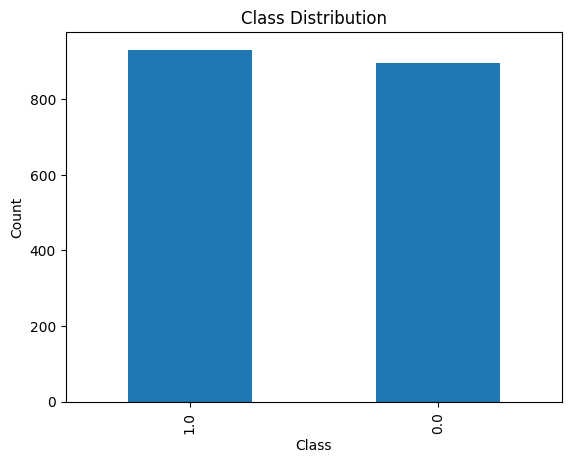

,Season,Team1Seed,Team2Seed,ScoreDiff,SeedDiff,IDTeams_c_score,NumOTmean_c_score,NumOTstd_c_score,WFGMmean_c_score,WFGMstd_c_score,WFGAmean_c_score,WFGAstd_c_score,WFGM3mean_c_score,WFGM3std_c_score,WFGA3mean_c_score,WFGA3std_c_score,WFTMmean_c_score,WFTMstd_c_score,WFTAmean_c_score,WFTAstd_c_score,WORmean_c_score,WORstd_c_score,WDRmean_c_score,WDRstd_c_score,WAstmean_c_score,WAststd_c_score,WTOmean_c_score,WTOstd_c_score,WStlmean_c_score,WStlstd_c_score,WBlkmean_c_score,WBlkstd_c_score,WPFmean_c_score,WPFstd_c_score,LFGMmean_c_score,LFGMstd_c_score,LFGAmean_c_score,LFGAstd_c_score,LFGM3mean_c_score,LFGM3std_c_score,LFGA3mean_c_score,LFGA3std_c_score,LFTMmean_c_score,LFTMstd_c_score,LFTAmean_c_score,LFTAstd_c_score,LORmean_c_score,LORstd_c_score,LDRmean_c_score,LDRstd_c_score,LAstmean_c_score,LAststd_c_score,LTOmean_c_score,LTOstd_c_score,LStlmean_c_score,LStlstd_c_score,LBlkmean_c_score,LBlkstd_c_score,LPFmean_c_score,LPFstd_c_score,TeamID,Gender
448,2010,16.0,16.0,17,0.0,1115_1457,0.0,-1.000000,17.000000,-1.000000,44.000000,-1.000000,6.000000,-1.000000,16.000000,-1.000000,21.000000,-1.000000,28.000000,-1.000000,10.000000,-1.000000,29.000000,-1.000000,12.000000,-1.000000,10.000000,-1.000000,3.000000,-1.000000,7.000000,-1.000000,16.000000,-1.000000,16.000000,-1.000000,55.000000,-1.000000,2.00,-1.000000,21.000000,-1.000000,10.000000,-1.000000,18.000000,-1.000000,14.000000,-1.000000,20.000000,-1.000000,5.000000,-1.000000,7.000000,-1.000000,3.000000,-1.000000,5.000000,-1.000000,22.000000,-1.000000,1115,1
449,2010,3.0,14.0,9,-11.0,1124_1358,0.0,0.000000,30.500000,7.141428,61.250000,6.075909,10.500000,4.041452,27.250000,5.500000,12.250000,3.500000,18.000000,5.477226,11.000000,4.242641,31.500000,6.757712,21.000000,6.000000,13.250000,3.593976,8.750000,0.500000,5.250000,4.031129,15.000000,2.581989,22.750000,2.500000,65.250000,5.315073,6.25,2.629956,27.500000,2.645751,5.000000,2.828427,8.500000,5.259911,10.000000,3.915780,22.750000,8.460693,15.500000,3.696846,14.000000,2.160247,5.000000,2.828427,2.000000,1.414214,18.750000,1.892969,1124,1
450,2010,5.0,12.0,18,-7.0,1139_1431,0.0,-1.000000,23.000000,-1.000000,50.000000,-1.000000,13.000000,-1.000000,31.000000,-1.000000,18.000000,-1.000000,28.000000,-1.000000,8.000000,-1.000000,24.000000,-1.000000,14.000000,-1.000000,10.000000,-1.000000,6.000000,-1.000000,1.000000,-1.000000,13.000000,-1.000000,24.000000,-1.000000,57.000000,-1.000000,4.00,-1.000000,18.000000,-1.000000,7.000000,-1.000000,9.000000,-1.000000,6.000000,-1.000000,24.000000,-1.000000,15.000000,-1.000000,14.000000,-1.000000,8.000000,-1.000000,1.000000,-1.000000,24.000000,-1.000000,1139,1
451,2010,7.0,10.0,7,-3.0,1140_1196,1.5,0.707107,31.500000,0.707107,65.000000,0.000000,10.500000,0.707107,28.500000,7.778175,17.500000,10.606602,27.000000,7.071068,10.000000,0.000000,29.000000,8.485281,17.000000,8.485281,13.500000,2.121320,10.000000,2.828427,3.500000,2.121320,14.500000,3.535534,29.500000,6.363961,74.500000,4.949747,10.00,0.000000,34.500000,3.535534,14.000000,0.000000,17.500000,2.121320,16.000000,5.656854,27.500000,3.535534,14.000000,1.414214,16.500000,6.363961,9.000000,2.828427,2.500000,2.121320,21.500000,3.535534,1140,1
452,2010,1.0,16.0,16,-15.0,1242_1250,0.0,-1.000000,38.000000,-1.000000,69.000000,-1.000000,9.000000,-1.000000,21.000000,-1.000000,5.000000,-1.000000,10.000000,-1.000000,14.000000,-1.000000,27.000000,-1.000000,17.000000,-1.000000,14.000000,-1.000000,10.000000,-1.000000,11.000000,-1.000000,18.000000,-1.000000,25.000000,-1.000000,62.000000,-1.000000,7.00,-1.000000,19.000000,-1.000000,17.000000,-1.000000,21.000000,-1.000000,13.000000,-1.000000,20.000000,-1.000000,11.000000,-1.000000,13.000000,-1.000000,6.000000,-1.000000,4.000000,-1.000000,16.000000,-1.000000,1242,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,2

In [4]:
# Check the distribution of the target variable 'Result'
class_distribution = y.value_counts()

# Print the distribution of the target variable
print(class_distribution)

# Optionally, you can also visualize it using a bar plot
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

X

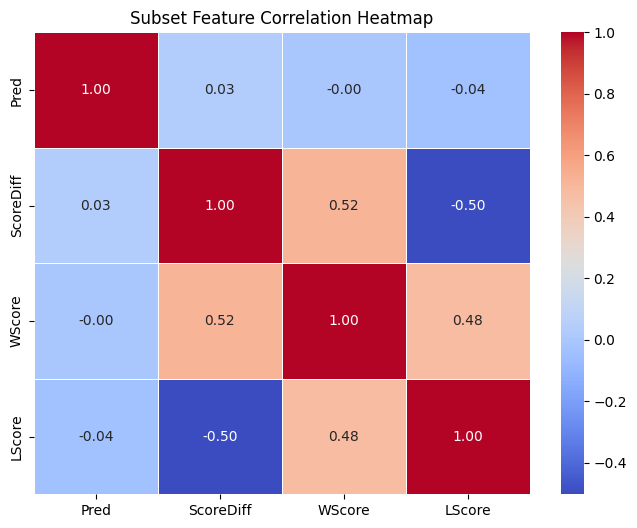


Correlation with Target 'Pred':
Pred         1.000000
ScoreDiff    0.034724
WScore      -0.000467
LScore      -0.036060
Name: Pred, dtype: float64


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only a subset of relevant columns
selected_columns = ['Pred', 'ScoreDiff', 'WScore', 'LScore']

# Select only numeric columns from the subset
numeric_games = games[selected_columns].select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_games.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Subset Feature Correlation Heatmap")
plt.show()

# Print the correlation of each feature with the target 'Pred'
print("\nCorrelation with Target 'Pred':")
print(corr_matrix['Pred'])


In [6]:
# Set pandas display option to avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Get feature importance
feature_importances = model.get_feature_importance()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#pd.set_option("display.max_rows", None)

# Print feature importance
feature_importance_df

,Feature,Importance
4,SeedDiff,9.06
3,ScoreDiff,4.95
1,Team1Seed,4.62
20,WORmean_c_score,3.57
2,Team2Seed,3.52
...,...,...
43,LFTMstd_c_score,0.40
11,WFGAstd_c_score,0.32
33,WPFstd_c_score,0.31
37,LFGAstd_c_score,0.30


In [7]:
import pandas as pd

pd.reset_option('display.max_rows')
sub_X = sub[col].fillna(-1)

# Generate predictions using the trained model and clip values between 0.001 and 0.999
sub['Pred'] = model.predict_proba(sub_X)[:, 1].clip(0.001, 0.999)

# Fill NaNs in the predictions (you can use 0, mean, or another strategy)
sub['Pred'] = sub['Pred'].fillna(-1)  # Replace -1 with an appropriate strategy if needed

# Save final predictions to a CSV file for submission
sub[['ID', 'Pred']].to_csv('submission.csv', index=False)

pd.set_option('display.max_columns', None)

# First merge for Team1
sub = sub.merge(teams[['TeamID', 'TeamName']], how='left', left_on='Team1', right_on='TeamID', suffixes=('_1', ''))

# Rename columns to avoid duplicate column names
sub = sub.rename(columns={'TeamName': 'TeamName_1', 'TeamID': 'TeamID_1'})

# Second merge for Team2
sub = sub.merge(teams[['TeamID', 'TeamName']], how='left', left_on='Team2', right_on='TeamID', suffixes=('', '_2'))

# Rename columns after the second merge
sub = sub.rename(columns={'TeamName': 'TeamName_2', 'TeamID': 'TeamID_2'})

# Now you can select the columns you want
sub[['ID', 'Pred', 'Team1', 'Team2', 'TeamName_1', 'TeamName_2', 'Gender']]

sub

,ID,Pred,WLoc,ScoreDiff,Season,Team1,Team2,IDTeams,IDTeam1,IDTeam2,Team1Seed,Team2Seed,SeedDiff,IDTeams_c_score,NumOTmean_c_score,NumOTstd_c_score,WFGMmean_c_score,WFGMstd_c_score,WFGAmean_c_score,WFGAstd_c_score,WFGM3mean_c_score,WFGM3std_c_score,WFGA3mean_c_score,WFGA3std_c_score,WFTMmean_c_score,WFTMstd_c_score,WFTAmean_c_score,WFTAstd_c_score,WORmean_c_score,WORstd_c_score,WDRmean_c_score,WDRstd_c_score,WAstmean_c_score,WAststd_c_score,WTOmean_c_score,WTOstd_c_score,WStlmean_c_score,WStlstd_c_score,WBlkmean_c_score,WBlkstd_c_score,WPFmean_c_score,WPFstd_c_score,LFGMmean_c_score,LFGMstd_c_score,LFGAmean_c_score,LFGAstd_c_score,LFGM3mean_c_score,LFGM3std_c_score,LFGA3mean_c_score,LFGA3std_c_score,LFTMmean_c_score,LFTMstd_c_score,LFTAmean_c_score,LFTAstd_c_score,LORmean_c_score,LORstd_c_score,LDRmean_c_score,LDRstd_c_score,LAstmean_c_score,LAststd_c_score,LTOmean_c_score,LTOstd_c_score,LStlmean_c_score,LStlstd_c_score,LBlkmean_c_score,LBlkstd_c_score,LPFmean_c_score,LPFstd_c_score,TeamID_1,Gender,TeamID_1,TeamName_1,TeamID_2,TeamName_2
0,2025_1101_1102,0.39,3,0,2025,1101,1102,1101_1102,2025_1101,2025_1102,0.00,0.00,0.00,1101_1102,0.00,-1.00,23.00,-1.00,54.00,-1.00,9.00,-1.00,25.00,-1.00,7.00,-1.00,15.00,-1.00,7.00,-1.00,17.00,-1.00,11.00,-1.00,13.00,-1.00,8.00,-1.00,4.00,-1.00,16.00,-1.00,25.00,-1.00,51.00,-1.00,3.00,-1.00,18.00,-1.00,5.00,-1.00,8.00,-1.00,5.00,-1.00,28.00,-1.00,15.00,-1.00,20.00,-1.00,5.00,-1.00,2.00,-1.00,14.00,-1.00,1101,1,1101,Abilene Chr,1102,Air Force
1,2025_1101_1103,0.98,3,0,2025,1101,1103,1101_1103,2025_1101,2025_1103,0.00,13.00,-13.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1101,1,1101,Abilene Chr,1103,Akron
2,2025_1101_1104,0.91,3,0,2025,1101,1104,1101_1104,2025_1101,2025_1104,0.00,2.00,-2.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1101,1,1101,Abilene Chr,1104,Alabama
3,2025_1101_1105,0.38,3,0,2025,1101,1105,1101_1105,2025_1101,2025_1105,0.00,0.00,0.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1101,1,1101,Abilene Chr,1105,Alabama A&M
4,2025_1101_1106,0.98,3,0,2025,1101,1106,1101_1106,2025_1101,2025_1106,0.00,16.00,-16.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1101,1,1101,Abilene Chr,1106,Alabama St
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131402,2025_3477_3479,0.67,3,0,2025,3477,3479,3477_3479,2025_3477,2025_3479,0.00,0.00,0.00,-1,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,

In [8]:
sub['Pred'].describe()

count   131407.00
mean         0.50
std          0.28
min          0.00
25%          0.34
50%          0.51
75%          0.67
max          1.00
Name: Pred, dtype: float64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from catboost import CatBoostClassifier

# Assuming you have the following:
# X - Feature matrix
# y - Target variable (0 or 1)
# cat_features - List of categorical feature columns
# best_params - Dictionary with best parameters for CatBoostClassifier

# 1. Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Initialize and train the model
model = CatBoostClassifier(**best_params)

# Fit the model on the training data
model.fit(X_train, y_train, cat_features=cat_features, verbose=100)

# 3. Predict probabilities on the validation set
y_val_pred_proba = model.predict_proba(X_val)[:, 1].clip(0.001, 0.999)  # Get probabilities for the positive class (winning team)

# 4. Convert probabilities to class labels (1 if prob >= 0.5, else 0)
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

# 5. Compute accuracy
accuracy = accuracy_score(y_val, y_val_pred)

# 6. Convert accuracy to percentage
accuracy_percentage = accuracy * 100

# 7. Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_val, y_val_pred_proba)

# 8. Print the results
print(f'Accuracy: {accuracy_percentage:.2f}%')
print(f'Mean Squared Error: {mse:.4f}')

0:	learn: 0.6184754	total: 23.8ms	remaining: 37.7s
100:	learn: 0.0014088	total: 2.31s	remaining: 33.9s
200:	learn: 0.0002542	total: 4.57s	remaining: 31.4s
300:	learn: 0.0002316	total: 6.78s	remaining: 28.9s
400:	learn: 0.0002315	total: 9.02s	remaining: 26.6s
500:	learn: 0.0002315	total: 11.6s	remaining: 25.1s
600:	learn: 0.0002315	total: 14s	remaining: 22.8s
700:	learn: 0.0002315	total: 16.2s	remaining: 20.4s
800:	learn: 0.0002314	total: 18.4s	remaining: 18s
900:	learn: 0.0002314	total: 20.6s	remaining: 15.6s
1000:	learn: 0.0002314	total: 22.8s	remaining: 13.3s
1100:	learn: 0.0002314	total: 25.1s	remaining: 11s
1200:	learn: 0.0002314	total: 27.3s	remaining: 8.67s
1300:	learn: 0.0002314	total: 29.5s	remaining: 6.4s
1400:	learn: 0.0002313	total: 31.7s	remaining: 4.12s
1500:	learn: 0.0002313	total: 34s	remaining: 1.85s
1582:	learn: 0.0002313	total: 35.8s	remaining: 0us
Accuracy: 71.04%
Mean Squared Error: 0.2254


In [10]:
import pandas as pd

# Create a DataFrame to compare predictions vs actual values
results_df = pd.DataFrame({
    'Actual': y_val.values,
    'Predicted Probability': y_val_pred_proba,
    'Predicted': y_val_pred
})

# Function to color rows based on correctness
def highlight_correctness(row):
    if row['Actual'] == row['Predicted']:
        return ['background-color: lightgreen'] * len(row)  # Green for correct predictions
    else:
        return ['background-color: lightcoral'] * len(row)  # Red for incorrect predictions

# Apply styling
styled_df = results_df.style.apply(highlight_correctness, axis=1)

# Count correct (green) and incorrect (red) predictions
correct_predictions = (results_df['Actual'] == results_df['Predicted']).sum()
incorrect_predictions = (results_df['Actual'] != results_df['Predicted']).sum()
total_predictions = len(results_df)

# Calculate percentages
correct_percentage = (correct_predictions / total_predictions) * 100
incorrect_percentage = (incorrect_predictions / total_predictions) * 100

# Print the counts of correct, incorrect predictions, and total predictions
print(f"Total Correct Predictions (Green): {correct_predictions} ({correct_percentage:.2f}%)")
print(f"Total Incorrect Predictions (Red): {incorrect_predictions} ({incorrect_percentage:.2f}%)")
print(f"Total Predictions: {total_predictions}")


# Display styled DataFrame
styled_df

Total Correct Predictions (Green): 260 (71.04%)
Total Incorrect Predictions (Red): 106 (28.96%)
Total Predictions: 366


,Actual,Predicted Probability,Predicted
0,1.000000,0.692338,1
1,1.000000,0.999000,1
2,0.000000,0.001000,0
3,1.000000,0.980302,1
4,1.000000,0.047799,0
5,0.000000,0.831544,1
6,0.000000,0.004704,0
7,1.000000,0.947058,1
8,1.000000,0.695210,1
9,0.000000,0.001000,0


In [11]:
filtered_sub = sub[
    (sub['TeamName_1'] == 'Michigan') & (sub['TeamName_2'] == 'Wisconsin')
][['ID', 'Pred', 'Team1', 'Team2', 'TeamName_1', 'TeamName_2', 'Gender']]

filtered_sub['Winner'] = filtered_sub.apply(lambda row: row['TeamName_1'] if row['Pred'] >= 0.5 else row['TeamName_2'], axis=1)

pd.set_option("display.max_rows", 20)
filtered_sub

,ID,Pred,Team1,Team2,TeamName_1,TeamName_2,Gender,Winner
46933,2025_1276_1458,0.28,1276,1458,Michigan,Wisconsin,1,Wisconsin
112469,2025_3276_3458,0.23,3276,3458,Michigan,Wisconsin,0,Wisconsin
